In [ ]:
!pip install -U datatable
!pip install -U pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 96.9 MB 111 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 4.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=1450e54e644f762449a566053e59ad64319cc3f46d85cbced7720fe1f6467fc7
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


In [ ]:
import datatable as dt
import nltk
nltk.download('stopwords') 
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


### Stop Words

In [ ]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english') #spanish
stop_words.extend(['\n', 'nan'])
stop_words.extend(['stay', 'stayed', 'service', 'got', 'room', 'night', 'food', 'did', 'rooms', 
'day', 'resort', 'hotel', 'beach', 'staff'])

### Dataset

In [ ]:
df = pd.read_csv('/content/tripadvisor_hotel_reviews.csv', decimal = '.', sep = ',')

conditions = [df.Rating.isin([1,2]), df.Rating.isin([3]), df.Rating.isin([4,5])]
values = [0,0,1]

df['Cluster'] =np.select(conditions, values)

df

,Review,Rating,Cluster
0,nice hotel expensive parking got good deal sta...,4,1
1,ok nothing special charge diamond member hilto...,2,0
2,nice rooms not 4* experience hotel monaco seat...,3,0
3,"unique, great stay, wonderful time hotel monac...",5,1
4,"great stay great stay, went seahawk game aweso...",5,1
...,...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5,1
20487,great location price view hotel great quick pl...,4,1
20488,"ok just looks nice modern outside, desk staff ...",2,0
20489,hotel theft ruined vacation hotel opened sept ...,1,0


### Tokenize words and Clean-up text

In [ ]:
data = df[df['Cluster'] == 0 ]

In [ ]:
%%time
# Convert to list
data = data.Review.astype('str') # DESCRIPCION OBSERVACIONES
data = data.values.tolist()


tokens = [t.lower() for t in data if t.lower() not in stop_words]
tokens = [re.sub('\s+', ' ', sent) for sent in tokens]
tokens = [re.sub('\d', ' ', sent) for sent in tokens] #Elimino los numeros
tokens = [re.sub(' +', ' ', sent) for sent in tokens] #Elimino multiples espacios en blanco
tokens = [str(sent).strip() for sent in tokens] # elimina espacios en blanco antes y despues del token
tokens = [re.sub('[^A-Za-z0-9]+', ' ', sent) for sent in tokens] #elimina los caracteres especiales


def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(tokens))

data_words[:10]

CPU times: user 2.95 s, sys: 57.8 ms, total: 3.01 s
Wall time: 3.15 s


### Creating Bigram and Trigram Models

In [ ]:
%%time
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=20, threshold=0.7) # higher threshold fewer phrases. valores entre 0 y uno
trigram = gensim.models.Phrases(bigram[data_words], threshold=10)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


CPU times: user 22.4 s, sys: 132 ms, total: 22.5 s
Wall time: 29.3 s


In [ ]:
# See trigram example
print(trigram_mod[bigram_mod[data_words[1452]]])

['good', 'hotel', 'personal', 'service_stayed', 'nights_hotel', 'residential', 'neighborhood', 'neighborhood', 'pubs', 'walking_distance', 'green', 'tube_station', 'near', 'berkley', 'sq', 'room', 'included', 'english', 'breakfast', 'nice', 'service', 'diningroom', 'food', 'so_so', 'buffet', 'included', 'limited', 'fruit', 'cereal', 'pasteries', 'sit', 'served', 'slices', 'toast', 'jam', 'immediately', 'room_small', 'crowded', 'american_standards', 'king_bed', 'fake', 'heavy', 'fur', 'comfortor', 'asked', 'removed', 'week', 'took', 'immediately', 'alot', 'furniture', 'small', 'space', 'tiny', 'closet', 'bathroom', 'big', 'marble', 'nice', 'room', 'hotel_clean', 'night', 'asked', 'extra', 'pillow', 'returned_room', 'turn_down', 'service', 'large', 'feather', 'pillows', 'linens', 'lovely', 'the', 'people', 'desk', 'quick', 'greet', 'helpful', 'asked', 'chris', 'check', 'reservations', 'leaving', 'no_problem', 'request', 'happy', 'helpful', 'directions', 'london', 'just', 'expensive', 'ri

### Remove Stopwords, Make Bigrams and Lemmatize

In [ ]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# !spacy download es_core_news_md

In [ ]:
# !spacy download en_core_web_sm


In [ ]:
%%time
#Let’s call the functions in order.
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'es' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner']) #es_core_news_md

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['ok_nothe', 'special', 'charge', 'diamond', 'member', 'decide', 'chain', 'shoot', 'anniversary', 'book', 'website', 'description', 'suite', 'bedroom', 'bathroom', 'standard', 'take', 'print', 'reservation', 'desk', 'show', 'say', 'tv', 'couch', 'tell', 'mixed', 'sorry', 'kid', 'embassy', 'suit', 'sit', 'bathroom', 'bedroom', 'offer', 'correct', 'false', 'advertising', 'send', 'website', 'email', 'ask', 'failure', 'advertise', 'website', 'reservation', 'description', 'furnish', 'hard', 'copy', 'reservation', 'duty', 'reply', 'solution', 'send', 'email', 'trip', 'guest', 'survey', 'follow', 'email', 'mail', 'guess', 'tell', 'concerned', 'guest', 'range', 'indifferent', 'helpful', 'spot', 'neighborhood', 'hood', 'tell', 'hotel', 'good', 'breakfast', 'spot', 'convenient', 'know', 'exist', 'inside', 'run', 'busy', 'chat', 'help', 'bag', 'prior', 'arrival', 'email', 'inform', 'anniversary', 'half', 'really', 'picky', 'want', 'good', 'nice', 'email', 'say', 'deliver', 'bottle', 'champagne',

### Create the Dictionary and Corpus needed for Topic Modeling

In [ ]:
%%time
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]


CPU times: user 786 ms, sys: 13 ms, total: 799 ms
Wall time: 803 ms


In [ ]:
id2word[2]

'anniversary'

In [ ]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:5]]

[[('advertise', 1),
  ('advertising', 1),
  ('anniversary', 2),
  ('arrival', 3),
  ('ask', 1),
  ('bag', 1),
  ('bathroom', 2),
  ('bedroom', 2),
  ('beds_comfortable', 1),
  ('book', 1),
  ('bottle', 1),
  ('breakfast', 1),
  ('bring', 1),
  ('build', 1),
  ('business', 1),
  ('busy', 1),
  ('celebrate', 1),
  ('chain', 2),
  ('champagne', 2),
  ('charge', 1),
  ('chat', 1),
  ('chocolate', 1),
  ('clean', 2),
  ('concerned', 1),
  ('control', 2),
  ('convenient', 1),
  ('copy', 1),
  ('correct', 1),
  ('couch', 1),
  ('cover', 1),
  ('decide', 1),
  ('deliver', 1),
  ('description', 2),
  ('desk', 1),
  ('diamond', 1),
  ('directly', 1),
  ('duty', 1),
  ('email', 5),
  ('embassy', 1),
  ('exist', 1),
  ('eye', 1),
  ('failure', 1),
  ('false', 1),
  ('foam', 2),
  ('follow', 1),
  ('furnish', 1),
  ('good', 4),
  ('green', 1),
  ('guess', 1),
  ('guest', 2),
  ('half', 1),
  ('hard', 1),
  ('heat', 1),
  ('help', 1),
  ('helpful', 1),
  ('high', 2),
  ('hood', 1),
  ('hotel', 2),
 

### Building the Topic Model

* chunksize: is the number of documents to be used in each training chunk. 
* update_every: determines how often the model parameters should be updated and 
* passes: is the total number of training passes.

In [ ]:
%%time
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           #per_word_topics=True
                                             )

CPU times: user 24.4 s, sys: 215 ms, total: 24.6 s
Wall time: 26 s


In [ ]:
# Print the Keyword in the 3 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.023*"wedding" + 0.019*"fix" + 0.011*"lock" + 0.010*"safe" + '
  '0.010*"properly" + 0.008*"steal" + 0.007*"function" + 0.006*"theft" + '
  '0.006*"degree" + 0.006*"worst"'),
 (1,
  '0.018*"pool" + 0.013*"people" + 0.013*"go" + 0.013*"drink" + 0.013*"good" + '
  '0.012*"restaurant" + 0.011*"water" + 0.010*"time" + 0.010*"eat" + '
  '0.008*"beautiful"'),
 (2,
  '0.016*"say" + 0.016*"tell" + 0.016*"check" + 0.014*"ask" + 0.012*"book" + '
  '0.011*"leave" + 0.011*"go" + 0.009*"time" + 0.009*"give" + 0.008*"come"'),
 (3,
  '0.011*"small" + 0.011*"clean" + 0.011*"good" + 0.010*"nice" + 0.010*"look" '
  '+ 0.009*"bed" + 0.008*"place" + 0.008*"area" + 0.008*"bathroom" + '
  '0.007*"really"')]


### Compute Model Perplexity and Coherence Score

In [ ]:
# Compute Perplexity
# print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.33444542073348293


### Visualize the topics-keywords

In [ ]:
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
# feed the LDA model into the pyLDAvis instance
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.134603  0.201798       1        1  40.463727
2      0.121061 -0.236785       2        1  31.328112
1      0.114624  0.029817       3        1  25.016505
0     -0.370288  0.005171       4        1   3.191656, topic_info=          Term         Freq        Total Category  logprob  loglift
526       pool  1788.000000  1788.000000  Default  30.0000  30.0000
113       tell  2006.000000  2006.000000  Default  29.0000  29.0000
132      check  1987.000000  1987.000000  Default  28.0000  28.0000
4          ask  1836.000000  1836.000000  Default  27.0000  27.0000
1198     drink  1331.000000  1331.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
664       safe   135.982287   430.126940   Topic4  -4.5593   2.2931
1679  security    64.339900   160.809079   Topic4  -5.3076   2.5286
1923    sister    57.866731   128.697310   Topic4  -5.4137   2.6453
3000      cash    44.005210    93.195350   Topic4  -5.6875   2.6942
2596     dream    39.219088   125.766619   Topic4  -5.8027   2.2794

[238 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
3189      3  0.995851  activity
1044      2  0.995318    advise
321       1  0.982904      area
321       3  0.016828      area
3         2  0.997905   arrival
...     ...       ...       ...
206       2  0.587243      work
206       3  0.141889      work
2119      4  0.984443     worst
746       1  0.037301     wrong
746       2  0.960493     wrong

[308 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 2, 1])

### Save the model

In [ ]:
# path_name = "./Gensim_models/interaction_model_descripcion.model"
# lda_model.save(path_name)

In [ ]:
# new = gensim.models.ldamodel.LdaModel.load(path_name)
# model_new_topics = new.show_topics(formatted=False)
# pprint(new.print_topics(num_words=40))

### Building LDA Mallet Model (It is no longer available)

In [ ]:
# mallet_path = '/home/sandovalj@lc.gc.local/tfx/mallet-2.0.8' # update this path
# ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=3, id2word=id2word)

# # Compute Coherence Score
# coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
# coherence_ldamallet = coherence_model_ldamallet.get_coherence()
# print('\nCoherence Score: ', coherence_ldamallet)

### Finding the optimal number of topics for LDA

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, random_state = 100, update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
#model_list


NameError: ignored

In [ ]:
# %%time
# model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=10, step=1)

In [ ]:
# # Show graph
# limit=10; start=2; step=1;
# x = range(start, limit, step)
# plt.plot(x, coherence_values)
# plt.xlabel("Num Topics")
# plt.ylabel("Coherence score")
# plt.legend(("coherence_values"), loc='best')
# plt.show()

In [ ]:
# # Print the coherence scores
# for m, cv in zip(x, coherence_values):
#     print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

#### Selecting the optimal model

In [ ]:
# Select the model and print the topics
# optimal_model = model_list[3]
# model_topics = optimal_model.show_topics(formatted=False)
# pprint(optimal_model.print_topics(num_words=10))

In [ ]:
# pyLDAvis.enable_notebook()
# vis_2 =  gensimvis.prepare(optimal_model, corpus, id2word)
# vis_2

A partir de 5 hay Solapamiento de Clusters y hay clusters con muy pocos registros, por eso se escogieron 4

### Save Optimal Model

In [ ]:
#optimal_model.save("./Gensim_models/interaction_model_observacion_reclamos.model")

# new = gensim.models.ldamodel.LdaModel.load("./Gensim_models/interaction_model_descripcion_reclamos.model")
# model_new_topics = new.show_topics(formatted=False)
# pprint(new.print_topics(num_words=20))

In [ ]:
# pprint(optimal_model.print_topics(num_words=10))

### Functions to sort the data

In [ ]:
###############Finding the dominant topic in each sentence
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

##################Find the most representative document for each topic
def most_representative_records(df_topic_sents_keywords):
    # Group top 5 sentences under each topic
    sent_topics_sorteddf = pd.DataFrame()

    sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

    for i, grp in sent_topics_outdf_grpd:
        sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], axis=0)

    # Reset Index    
    sent_topics_sorteddf.reset_index(drop=True, inplace=True)

    # Format
    sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
    
    return sent_topics_sorteddf

################Topic distribution across documents
def topic_distribution(df_topic_sents_keywords):
    # Number of Documents for Each Topic
    topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

    # Percentage of Documents for Each Topic
    topic_contribution = round(topic_counts/topic_counts.sum(), 4)

    # Topic Number and Keywords
    topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']].value_counts()
    topic_num_keywords = pd.DataFrame(topic_num_keywords)
    topic_num_keywords = topic_num_keywords.reset_index().drop(0, axis=1)

    # Concatenate Column wise
    df_dominant_topics = pd.concat([topic_counts, topic_contribution], axis=1)
    df_dominant_topics = df_dominant_topics.reset_index()
    df_dominant_topics = pd.concat([topic_num_keywords, df_dominant_topics], axis=1)
    # Change Column names
    df_dominant_topics.columns = ['Dominant_topic', 'Topic_Keywords', 'to_delete', 'Num_Documents', 'Perc_Documents']
    del  df_dominant_topics['to_delete']

    # Show
    return df_dominant_topics

### Finding the dominant topic in each sentence

In [ ]:
optimal_model = lda_model 

df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
# df_dominant_topic.head(10)

In [ ]:
df_dominant_topic.Dominant_Topic.unique()

array([2., 3., 1.])

In [ ]:
optimal_model.show_topics()

[(0,
  '0.023*"wedding" + 0.019*"fix" + 0.011*"lock" + 0.010*"safe" + 0.010*"properly" + 0.008*"steal" + 0.007*"function" + 0.006*"theft" + 0.006*"degree" + 0.006*"worst"'),
 (1,
  '0.018*"pool" + 0.013*"people" + 0.013*"go" + 0.013*"drink" + 0.013*"good" + 0.012*"restaurant" + 0.011*"water" + 0.010*"time" + 0.010*"eat" + 0.008*"beautiful"'),
 (2,
  '0.016*"say" + 0.016*"tell" + 0.016*"check" + 0.014*"ask" + 0.012*"book" + 0.011*"leave" + 0.011*"go" + 0.009*"time" + 0.009*"give" + 0.008*"come"'),
 (3,
  '0.011*"small" + 0.011*"clean" + 0.011*"good" + 0.010*"nice" + 0.010*"look" + 0.009*"bed" + 0.008*"place" + 0.008*"area" + 0.008*"bathroom" + 0.007*"really"')]

### Find the most representative document for each topic

In [ ]:
pd.set_option('display.max_colwidth', None)
sent_topics_sorteddf = most_representative_records(df_topic_sents_keywords)
sent_topics_sorteddf

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,1.0,0.7641,"pool, people, go, drink, good, restaurant, water, time, eat, beautiful","beautiful beach planning punta cana dominican rep. recommend beautiful resort natura park eco resort, resort beautiful natural environment wild birds quiet clean rooms great friendly people not staff speak english willing make vacation enjoyable, beach beautiful white sand walk forever, no vendors harassing guests beach, water clear beach maintained plenty lounge chairs, usual resort activities volleyball water polo meringue lessons.on hand experience things management improve make 5 star resort, example like alcoholic beverages prepared drink lot opinion bottles diluted not sure, wine poured large white plastic bleach container purchased inclusive package right la carte dinners 3 restaurants advice drink wine red white purchase duty free spanish house wine serve meals terrible, food better buffet resort food drink not highlight.talking buffet personal opinion general ok. meals buffet greasy salty seafood not great expected, little sick eating seafood not sure seafood cause, prepared big bottle pepto bismol helps, good piece advice bring small bills american dollars difficult change large bills small ones, tip room maid day plenty water coffee beer extra towels changed linens want, spa site extra charge mud massage called fango great, 3 clay tennis available, spending week natura park time enjoyable good time beautiful place people hospitable, won__Ç_é_ come try resort caribbean time,"
1,2.0,0.8920,"say, tell, check, ask, book, leave, go, time, give, come","beware making reservations beware making reservation, fiance called separately book night stay jazz festival, told room available booked room stay, book non-refundable airline reservations, day received fax confirmation staying 4 nights instead 3. called informed 4 night minimum jazz festival, reservations agent not told minimum nor did fax state minimum, tried rearrange schedule not, hotel not mentioned multiple calls reserving room paid non-refundable airline tickets based converstion reservation agent hoped waive 4th night requirement allow stay 3 nights, apologized misunderstanding refused, heard hotel beautiful stay recommend anybody way treated,"
2,3.0,0.9171,"small, clean, good, nice, look, bed, place, area, bathroom, really","not bad price given central downtown location low price moore good value two-star, price not fancy adequate clean roomy, elevator hallways small dingy rooms fine, beds good tv sufficient channel selection telephone bathroom normal size adequate motel-type towels/face cloths soap no shampoo, no air conditioning small fan room barely sufficient, rural area did n't street noise bad hotel facing 1st, ave. expect city not objectional running fan white noise helps, definitely concur reviewers upper floor 5 higher definitely recommended, free internet service lobby, staff not overly helpful friendly provided acceptable service, best thing central location pike market good restaurants downtown sites free bus ride area,"


### Topic distribution across documents

In [ ]:
df_dominant_topics = topic_distribution(df_topic_sents_keywords)
df_dominant_topics

,Dominant_topic,Topic_Keywords,Num_Documents,Perc_Documents
0,3.0,"small, clean, good, nice, look, bed, place, area, bathroom, really",3307,0.6126
1,2.0,"say, tell, check, ask, book, leave, go, time, give, come",1255,0.2325
2,1.0,"pool, people, go, drink, good, restaurant, water, time, eat, beautiful",836,0.1549


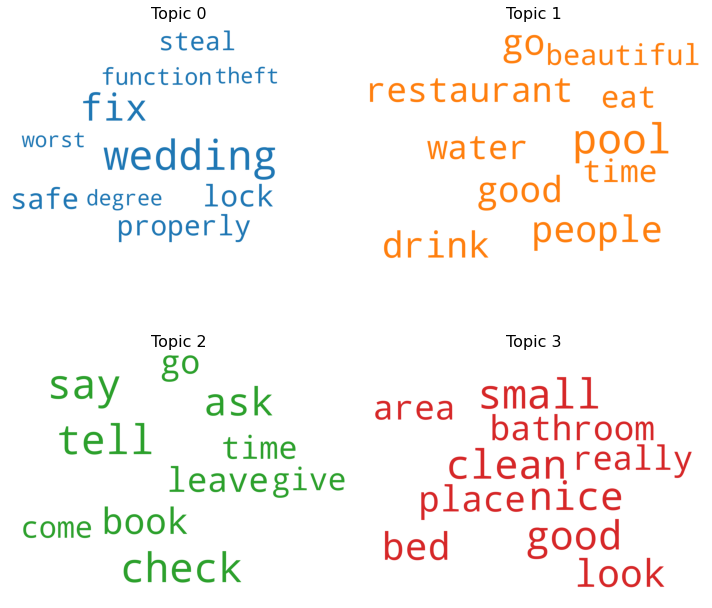

In [ ]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()